# DCGAN - TensorFlow using CIFAR10

### 작성자: 고려대학교 수학과 석사과정 최선묵

[References]  
- [Goodfellow's GAN Paper Link](https://proceedings.neurips.cc/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf)  
- [DCGAN Paper Link](https://arxiv.org/pdf/1511.06434.pdf)


In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Reshape, GlobalAveragePooling2D
from tensorflow.keras.activations import relu, tanh
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

import torch
import torchvision.utils as vutils

## Data Preparation

In [4]:
# Download MNIST dataset in numpy array format
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Reshape it into 4-dim'l tensor and convert the type for `int` into `float`
train_images = X_train.reshape((X_train.shape[0], 32, 32, 3)).astype('float32')
test_images = X_test.reshape((X_test.shape[0], 32, 32, 3)).astype('float32')

# Set the pixel values from -1 to 1
train_images = (train_images/255.0) * 2 - 1
test_images = (test_images/255.0) * 2 - 1

# Shuffle and seperate into batches
BATCH_SIZE = 128
train_images_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_images.shape[0]).batch(BATCH_SIZE)
test_images_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(test_images.shape[0]).batch(BATCH_SIZE)

2023-01-26 14:01:08.309971: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-26 14:01:08.320392: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Deep Convolutional GANs

### Architecture guidelines for stable Deep Convolutional GANs

- Replace any pooling layers with `strided convolutions` (discriminator) and `fractional-strided convolutions` (generator).
- Use `BatchNormaliziation` in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use `ReLU` activation in `generator` for all layers except for the output, which uses Tanh.
- Use `LeakyReLU` activation in the `discriminator` for all layers.

In [5]:
## Hyperparameters
latent_dim = 100

EPOCHS = 50
LR = 2e-4
BETA1 = 0.5 # for Adam optimizer


### Weight Initialization

In [6]:
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.02)

### Generator

In [7]:
def create_generator(input_size=latent_dim):
    input_tensor = Input(shape=(input_size))

    x = Reshape(target_shape=(2,2,25))(input_tensor)
    x = UpSampling2D(size=(2,2), interpolation='bilinear')(x)
    x = Conv2D(256, kernel_size=(5,5), strides=1, padding='same', 
               use_bias=False, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = relu(x, alpha=0.0)

    x = UpSampling2D(size=(2,2), interpolation='bilinear')(x)
    x = Conv2D(128, kernel_size=(5,5), strides=1, padding='same', 
               use_bias=False, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = relu(x, alpha=0.0)

    x = UpSampling2D(size=(2,2), interpolation='bilinear')(x)
    x = Conv2D(64, kernel_size=(5,5), strides=1, padding='same', 
               use_bias=False, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = relu(x, alpha=0.0)

    x = UpSampling2D(size=(2,2), interpolation='bilinear')(x)
    x = Conv2D(32, kernel_size=(5,5), strides=1, padding='same', 
               use_bias=False, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = relu(x, alpha=0.0)
    
    x = Conv2D(3, kernel_size=(3,3), strides=1, padding='same', 
               use_bias=True, activation='tanh', kernel_initializer=initializer)(x)

    model = Model(inputs=input_tensor, outputs=x)
    
    return model

In [8]:
g_model = create_generator()
g_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
reshape (Reshape)            (None, 2, 2, 25)          0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 4, 4, 25)          0         
_________________________________________________________________
conv2d (Conv2D)              (None, 4, 4, 256)         160000    
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 256)         1024      
_________________________________________________________________
tf.nn.relu (TFOpLambda)      (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 256)         0     

### Discriminator

In [9]:
def create_discriminator(input_shape=(32,32,3)):

    input_tensor = Input(shape=input_shape)
    x = Conv2D(32, kernel_size=(3,3), strides=2, padding='same', 
               use_bias=False, kernel_initializer=initializer)(input_tensor)
    x = BatchNormalization()(x)
    x = relu(x, alpha=0.2)

    x = Conv2D(64, kernel_size=(3,3), strides=2, padding='same', 
               use_bias=False, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = relu(x, alpha=0.2)

    x = Conv2D(128, kernel_size=(3,3), strides=2, padding='same', 
               use_bias=False, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = relu(x, alpha=0.2)

    x = Conv2D(256, kernel_size=(3,3), strides=1, padding='same', 
               use_bias=False, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = relu(x, alpha=0.2)

    x = GlobalAveragePooling2D()(x)

    x = Dense(units=64, use_bias=False, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = relu(x, alpha=0.2)
    x = Dense(units=1, use_bias=True, activation='sigmoid', kernel_initializer=initializer)(x)

    model = Model(inputs=input_tensor, outputs=x)

    return model
    


In [10]:
d_model = create_discriminator()
d_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 32)        864       
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
tf.nn.leaky_relu (TFOpLambda (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 64)          18432     
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
tf.nn.leaky_relu_1 (TFOpLamb (None, 8, 8, 64)          0   

### GAN model

In [26]:
class GAN(tf.keras.Model):
    def __init__(self, generator, discriminator, noise_size=latent_dim, d_iter=1):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.noise_size = noise_size
        self.d_iter = d_iter
        self.img_list = []

    def compile(self, d_optimizer, g_optimizer):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer

    def create_gen_input(self, batch_size):
        noise = tf.random.normal([batch_size, self.noise_size])
        return noise

    def train_step(self, real_img):
        
        criterion = BinaryCrossentropy()
        batch_size = tf.shape(real_img)[0]
        
        # Train Discriminator d_iter times with fixed generator.
        for _ in range(self.d_iter):
            with tf.GradientTape() as d_tape: 
                self.discriminator.trainable = True
                self.generator.trainable = False
                d_tape.watch(self.discriminator.trainable_variables)

                # Train discriminator using half batch real images. Real images have labels 1.
                real_label = tf.ones((batch_size, 1))
                d_real_output = self.discriminator(real_img)
                d_loss_real = criterion(real_label, d_real_output)

                # Train discriminator using half batch fake images. Fake images have labels 0. 
                fake_label = tf.zeros((batch_size, 1))

                # Create generator input 
                noise = self.create_gen_input(batch_size=batch_size)

                # Create fake image batch
                fake_img = self.generator(noise)
                d_fake_output = self.discriminator(fake_img)
                d_loss_fake = criterion(fake_label, d_fake_output)

                # Total Loss of Discriminator 
                d_loss = d_loss_real + d_loss_fake

            # Compute gradients
            d_gradients = d_tape.gradient(d_loss, self.discriminator.trainable_variables)

            # Optimize
            self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))

        # Train Generator with fixed discriminator.
        with tf.GradientTape() as g_tape:
            self.discriminator.trainable = False
            self.generator.trainable = True
            g_tape.watch(self.generator.trainable_variables)
            
            # Train generator using fake batch images. Fake images have labels 1 for generators.
            fake_img = self.generator(noise)
            d_fake_output = self.discriminator(fake_img)
            g_loss = criterion(real_label, d_fake_output)
        
        g_gradients = g_tape.gradient(g_loss, self.generator.trainable_variables) # Compute gradients
        self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables)) # Optimize

        return {"d_loss_real": d_loss_real, "d_loss_fake": d_loss_fake, "g_loss": g_loss}

    def valid_step(self, noise, label):

        fake_img = self.generator(noise, training=False)
        self.img_list.append(fake_img)



In [28]:
gan = GAN(generator=g_model, discriminator=d_model)

gan.compile(d_optimizer=Adam(learning_rate=LR, beta_1 = BETA1, beta_2=0.999),
            g_optimizer=Adam(learning_rate=LR, beta_1 = BETA1, beta_2=0.999)
            )

valid_noise = tf.random.normal([64, latent_dim], seed=830)

history = gan.fit(train_images_dataset, epochs=EPOCHS, validation_data=(valid_noise, None))

Epoch 1/80


2023-01-26 14:28:28.758381: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


 10/391 [..............................] - ETA: 8:53 - d_loss_real: 0.6930 - d_loss_fake: 0.6930 - g_loss: 0.6934

KeyboardInterrupt: 

In [31]:
img_list = gan.img_list

In [11]:
# Save trained models

g_model.save('saved_models/generator')
d_model.save('saved_models/discriminator')

INFO:tensorflow:Assets written to: saved_models/generator/assets
INFO:tensorflow:Assets written to: saved_models/discriminator/assets


In [12]:
# Load trained models

g_model = tf.keras.models.load_model('saved_models/generator')
d_model = tf.keras.models.load_model('saved_models/discriminator')

## Test

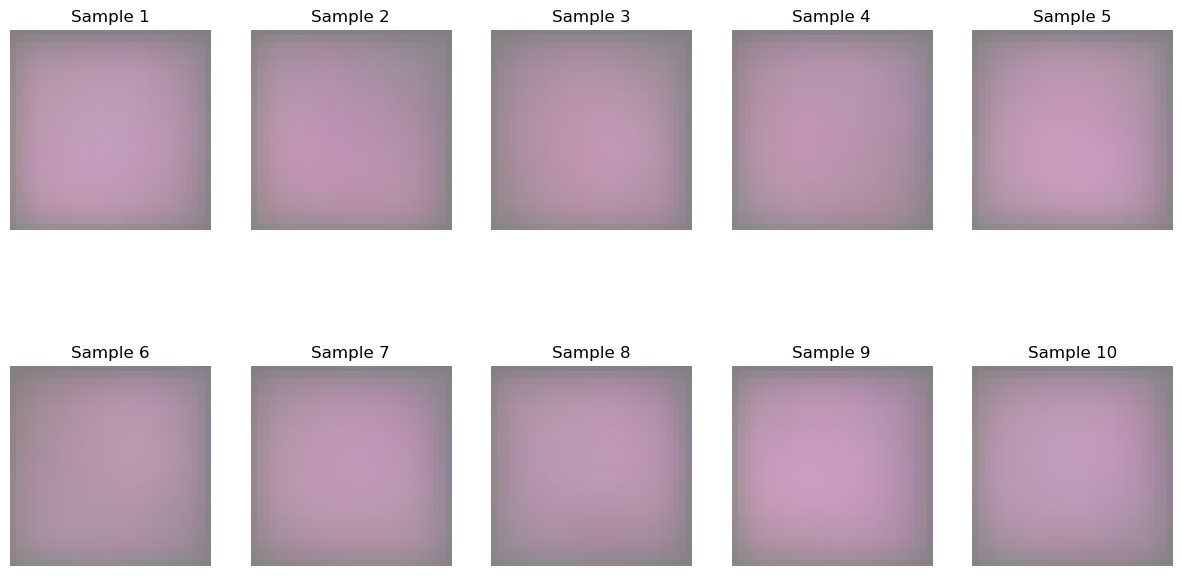

In [34]:
noise = tf.random.normal([10, latent_dim], seed=127)
generated_images = g_model(noise)
generated_images = (generated_images + 1)/2 # convert the values from [-1,1] to [0,1] for plots

plt.rcParams['figure.figsize'] = (15.0, 8.0)

rows = 2
columns = 5

for i in range(10) : 
    image_index = i+1      # image index 
    title = "Sample {}".format(image_index) # image title
    plt.subplot(rows, columns, image_index) # subplot 
    plt.title(title)   # title 
    plt.axis('off')
    plt.xticks([])  # x = None 
    plt.yticks([])  # y = None
    plt.imshow(generated_images[i])  
plt.show()


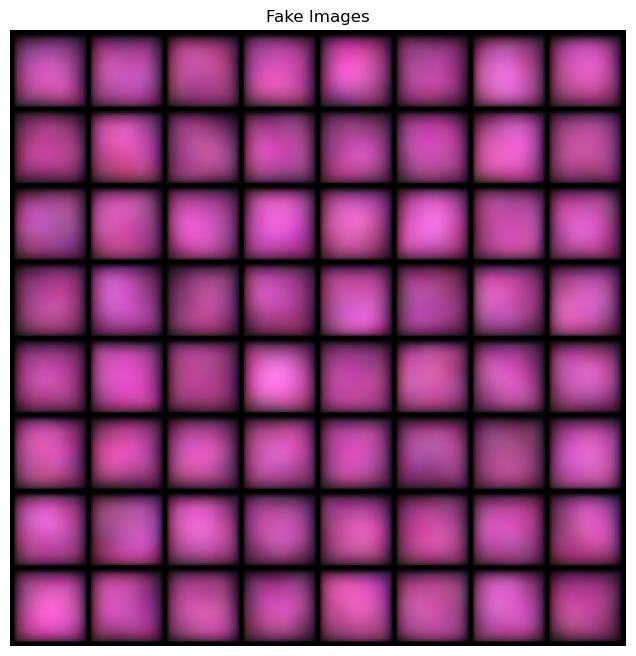

In [30]:
noise = tf.random.normal([64, latent_dim], seed=831)
fake = g_model(noise)

fake_tensor = torch.tensor(np.transpose(np.array(fake), (0,3,1,2)))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake_tensor, padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()
